![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым 
 функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [244]:
import numpy as np

In [245]:
#!pip install tensorflow

In [246]:
import tensorflow as tf
tf.__version__

'2.5.0'

# 0. Tensoflow teaser





Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

Но давайте еще сравним скорость выполнения с простым питоном.

In [9]:
def python_sum_squares(N):
    return sum([val ** 2 for val in range(N)])

In [10]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [11]:
N = 10**8

Будет долго..почему так, у кого какие идеи?

In [12]:
%time python_sum_squares(N)

Wall time: 57.1 s


333333328333333350000000

In [13]:
%timeit np_sum_squares(N)

444 ms ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их работает не сильно быстрее или даже медленнее, чем numpy.

In [14]:
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [15]:
%%timeit
tf_sum_squares(N)

735 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё ускорит код. 

In [16]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [17]:
%%timeit
tf_sum_squares(N)

The slowest run took 342.52 times longer than the fastest. This could mean that an intermediate result is being cached.
20 ms ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.
Однако стоит помнить, что в таких случая первый запуск всегда будет дольше, надо "прогреть" кэш.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [18]:
# можно задать тензор из нулей
tf.zeros([3, 4])

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [19]:
tf.zeros([2,2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [20]:
# или из единиц, но уже более сложной размерности
tf.ones([2,2,2])

<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]]], dtype=float32)>

In [22]:
# так можно сгенерировать диагональную матрицу
tf.eye(3,3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [23]:
# так можно сгенерировать диагональную матрицу кастомной размерности
tf.eye(3, 2)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [0., 0.]], dtype=float32)>

In [24]:
#генерируем числа от 1 до 4. Не итератор, сразу все отдает в память!
tf.range(1, 5, 1)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4])>

In [25]:
#транспонирование
tf.transpose(tf.eye(3, 2))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

In [28]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.8827343 , -0.68831164],
       [ 0.6598038 ,  0.1135325 ]], dtype=float32)>

In [29]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [30]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [31]:
# а потом перевести её в тензор
tf.convert_to_tensor(x, tf.float32) 

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [4., 3., 2., 1.]], dtype=float32)>

In [32]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])>

In [33]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [34]:
x.dtype

tf.float32

In [35]:
x.shape

TensorShape([3, 4])

In [36]:
x[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

In [37]:
x[:,1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 2.,  6., 10.], dtype=float32)>

In [38]:
x + 10

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[11., 12., 13., 14.],
       [15., 16., 17., 18.],
       [19., 20., 21., 22.]], dtype=float32)>

In [39]:
x[x > 3]

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.], dtype=float32)>

In [40]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [41]:
x + y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[13., 13., 13., 13.],
       [13., 13., 13., 13.],
       [13., 13., 13., 13.]], dtype=float32)>

In [42]:
x**y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1.00000e+00, 2.04800e+03, 5.90490e+04, 2.62144e+05],
       [3.90625e+05, 2.79936e+05, 1.17649e+05, 3.27680e+04],
       [6.56100e+03, 1.00000e+03, 1.21000e+02, 1.20000e+01]],
      dtype=float32)>

In [43]:
tf.math.exp(x)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[2.7182817e+00, 7.3890562e+00, 2.0085537e+01, 5.4598148e+01],
       [1.4841316e+02, 4.0342877e+02, 1.0966332e+03, 2.9809580e+03],
       [8.1030835e+03, 2.2026465e+04, 5.9874141e+04, 1.6275478e+05]],
      dtype=float32)>

In [44]:
tf.matmul(x, y, transpose_b=True)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[100.,  60.,  20.],
       [268., 164.,  60.],
       [436., 268., 100.]], dtype=float32)>

In [45]:
x

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)>

In [46]:
tf.reshape(x, [4, 3])

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]], dtype=float32)>

In [47]:
tf.reshape(x, [2, 2, 3])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]],

       [[ 7.,  8.,  9.],
        [10., 11., 12.]]], dtype=float32)>

In [48]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy()

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)

In [49]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

Попробуем реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [50]:
x = tf.linspace(-1.,1.,10)
sigmoid = 1./(1+tf.exp(-x))

sigmoid

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.26894143, 0.314799  , 0.36457646, 0.41742983, 0.47225076,
       0.52774924, 0.5825702 , 0.6354236 , 0.685201  , 0.7310586 ],
      dtype=float32)>

Попробуем реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \frac{1}{n} \sum_{i=1}^n (\hat y - y)^2
$$

In [51]:
y_true = tf.constant([1.,2.,3.,4.,5.],tf.float32)
y_pred = tf.constant([10.,20.,30.,40.,50.],tf.float32)
diff = y_true-y_pred
mse = tf.reduce_mean(tf.pow(diff,2))

mse

<tf.Tensor: shape=(), dtype=float32, numpy=891.0>

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [52]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = y**2

In [53]:
t.gradient(z, x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.6, 2.6], dtype=float32)>

In [54]:
t.gradient(z, y)

<tf.Tensor: shape=(), dtype=float32, numpy=2.6>

Нарисуем функцию и её производную на картинке :) 

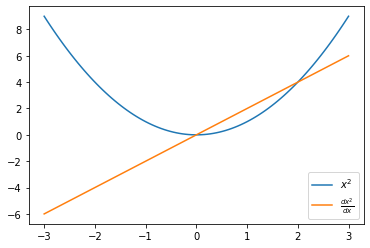

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();


Реализуем расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [56]:
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(w)
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))

df_dw = t.gradient(f,w)

df_dw

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [57]:
w = tf.Variable(initial_value=0.5)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>

In [58]:
x = np.array([1,2,3], dtype=float)
x

array([1., 2., 3.])

In [59]:
x*w

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 1. , 1.5], dtype=float32)>

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

Реализуем расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [60]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])
with tf.GradientTape() as t:
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))

df_dw = t.gradient(f,w)

df_dw

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [61]:
celsius = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


In [62]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

(array([-0.08906768], dtype=float32), array([-1.5120631], dtype=float32))

In [63]:
# Наша модель
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [66]:
linear_regression(celsius).numpy()

array([ 60.393456  ,  15.031564  ,  -0.08906768, -12.185573  ,
       -22.770014  , -33.354458  , -57.54747   ], dtype=float32)

In [67]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

8157.4688

In [125]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))
    pass

In [74]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([0.00622421], dtype=float32)>

In [78]:
model_train(celsius, fahrenheit)

In [79]:
print(f'bias = {a.numpy()[0]: .2f}, k = {b.numpy()[0]: .2f}')

bias =  0.13, k =  2.07


In [80]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

step: 0, loss: 969.075867, a: 0.186335, b: 2.065310
step: 100, loss: 659.787659, a: 5.741641, b: 2.019150
step: 200, loss: 449.217560, a: 10.325428, b: 1.980466
step: 300, loss: 305.857147, a: 14.107593, b: 1.948548
step: 400, loss: 208.254303, a: 17.228329, b: 1.922211
step: 500, loss: 141.804077, a: 19.803312, b: 1.900480
step: 600, loss: 96.563118, a: 21.927992, b: 1.882549
step: 700, loss: 65.762352, a: 23.681093, b: 1.867754
step: 800, loss: 44.792561, a: 25.127607, b: 1.855547
step: 900, loss: 30.515812, a: 26.321161, b: 1.845474
step: 1000, loss: 20.795950, a: 27.305979, b: 1.837163
step: 1100, loss: 14.178401, a: 28.118578, b: 1.830305
step: 1200, loss: 9.673082, a: 28.789061, b: 1.824646
step: 1300, loss: 6.605724, a: 29.342299, b: 1.819978
step: 1400, loss: 4.517455, a: 29.798775, b: 1.816125
step: 1500, loss: 3.095680, a: 30.175432, b: 1.812947
step: 1600, loss: 2.127741, a: 30.486208, b: 1.810324
step: 1700, loss: 1.468730, a: 30.742640, b: 1.808160
step: 1800, loss: 1.0200

In [81]:
print(f'bias = {a.numpy()[0]: .2f}, k = {b.numpy()[0]: .2f}')

bias =  31.27, k =  1.80


Можно сделать то же самое, но с визуализацией. 

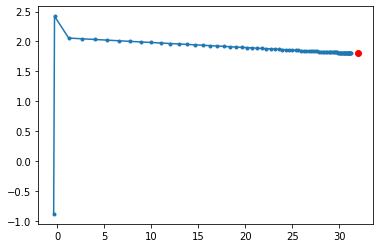

In [82]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')


ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [161]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [84]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [85]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

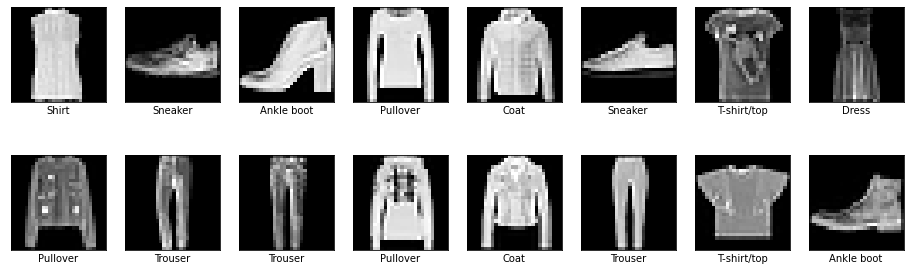

In [86]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [87]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Картинка - матрица. 

In [162]:
X_train[0].shape

(28, 28)

Давайте отнормируем выборку. 

In [163]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [164]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [165]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

tf.keras.utils.to_categorical(y_train)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [166]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [167]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Домашнее задание

In [313]:
num_classes = 10 # число классов
num_features = 784 # число фичей
num_hun = 100

W = tf.Variable(tf.random.normal([num_features,100]),tf.float32) 
b = tf.Variable(tf.random.normal([100]),tf.float32)

W2 = tf.Variable(tf.random.normal([100,10]),tf.float32)

# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

# прогнозы
def logistic_regression(X):
    # ваша модель
    print(X.shape)
    print(W.shape)
    lin_prod = tf.matmul(X,W)+b
    lin_prod2 = tf.matmul(tf.nn.sigmoid(lin_prod),W2)
    return tf.nn.softmax(lin_prod2)

# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

In [314]:
p_pred = logistic_regression(X_train[:3])
p_pred

(3, 784)
(784, 100)


<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[3.7812040e-08, 2.0818290e-11, 4.5657642e-03, 7.2038005e-05,
        6.4913671e-05, 5.3806318e-04, 9.3023664e-01, 1.7704856e-07,
        7.2854419e-07, 6.4521633e-02],
       [3.6235685e-11, 5.2914956e-10, 2.3230296e-04, 1.7647019e-03,
        5.9846911e-04, 3.3810522e-04, 9.8914427e-01, 2.3533775e-10,
        2.5082441e-04, 7.6714214e-03],
       [2.5176090e-09, 1.4255115e-09, 3.5495148e-05, 1.7889442e-02,
        8.7617813e-03, 1.2265297e-05, 9.0428424e-01, 1.4593896e-08,
        4.4250535e-03, 6.4591743e-02]], dtype=float32)>

Не очень понятны прогнозы, давайте приведем их к более человеческому виду)

In [315]:
tf.argmax(p_pred, axis=1)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([6, 6, 6], dtype=int64)>

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [316]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1))

Чтобы избежать проблем с бесконечностями, обычно logloss считают по-другому, с помощью функции tf.nn.softmax_cross_entropy_with_logits. Откуда берутся проблемы в виде бесконечностей в softmax либо посмотрите во второй лекции, либо в Николенко на страницах  133−135.

In [317]:
p_pred = logistic_regression(X_train)
logloss(p_pred, y_train)

(60000, 784)
(784, 100)


<tf.Tensor: shape=(), dtype=float32, numpy=11.16633>

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [318]:
def accuracy(y_pred, y_true):
    correct_pred = tf.equal(tf.argmax(y_pred,axis=1),tf.argmax(y_true,axis=1))
    
    return tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [319]:
accuracy(p_pred, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14085>

Задаём оптимизатор

In [320]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [321]:
@tf.function
def model_train(X, Y):
    with tf.GradientTape() as g:
        pred = logistic_regression(X)
        loss = logloss(pred,Y)
    gradients = g.gradient(loss,[W,b])

# Считаем градиенты
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [322]:
# Работает ли?
model_train(X_train, y_train)

(60000, 784)
(784, 100)
(60000, 784)
(784, 100)


Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [323]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [324]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

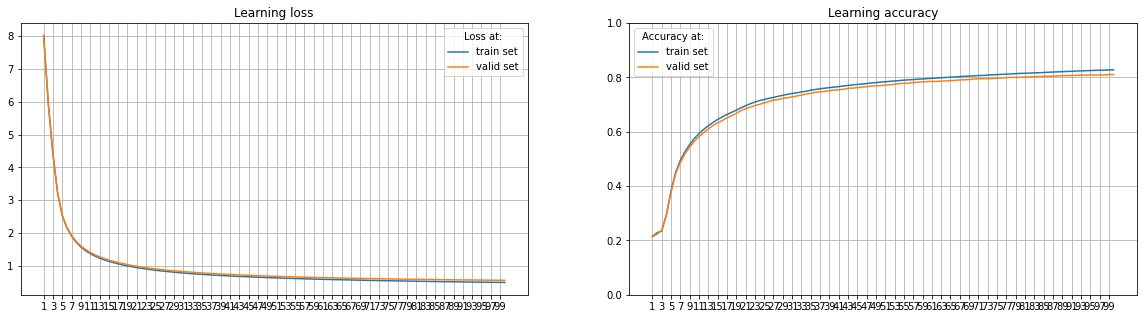

In [325]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        model_train(batch_x,batch_y)
        
        # Делаем щаг градиентного спуска 
        ### Ваш код для шага на текущем батче

        ########################
    
    # в конце эпохи считаем метрики
    p_train = logistic_regression(X_train)
    p_test = logistic_regression(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.